In [1]:
# import the libraries
import pandas as pd 
import numpy as np 
from pathlib import Path
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from ngboost import NGBRegressor
from ngboost.distns import Exponential, Normal, LogNormal
import seaborn as sns
from math import sqrt
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split

In [2]:
# Load the data
tensile_df =  pd.read_excel("../Tensile_Properties_Data.xlsx", header=0, skiprows=1)
tensile_df

,Reference,Material,Material Group,C (wt.%),Si (wt.%),Mn (wt.%),P (wt.%),S (wt.%),Ni (wt.%),Cr (wt.%),...,Width (mm),Aspect Ratio (L/W),Aspect Ratio (R/W),Aspect Ratio (T/W),Test Temperature (C),Strain Rate (1/s),Yield Strength (MPa),Ultimate Tensile Strength (MPa),Uniform Elongation (%),Total Elongation (%)
0,1,SS304L,"NSM, Rector Internals",0.02,0.45,1.30,NaN,NaN,8.02,18.30,...,1.2,4.166700,1.1667,0.625000,23.0,0.001000,274.0,789.0,67.00,76.00
1,1,SS304L,"NSM, Rector Internals",0.02,0.45,1.30,NaN,NaN,8.02,18.30,...,0.8,4.437500,0.3750,0.500000,23.0,0.001000,272.0,781.0,69.00,80.00
2,1,FeCrAl,"NSM, Fuel Cladding",NaN,0.13,NaN,NaN,NaN,NaN,13.10,...,1.2,4.166700,1.1667,0.416667,23.0,0.001000,710.0,767.0,7.90,14.80
3,1,FeCrAl,"NSM, Fuel Cladding",NaN,0.13,NaN,NaN,NaN,NaN,13.10,...,0.8,3.187500,0.3750,0.500000,23.0,0.001000,607.0,760.0,10.80,23.10
4,1,FeCrAl,"NSM, Fuel Cladding",NaN,0.13,NaN,NaN,NaN,NaN,13.10,...,0.8,3.187500,0.3750,0.500000,23.0,0.001000,725.0,782.0,6.60,18.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1468,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,114.0,0.222807,NaN,0.114035,760.0,0.000067,214.0,572.0,59.35,67.66
1469,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,NaN,NaN,NaN,NaN,760.0,0.000067,207.0,494.0,38.80,47.80
1470,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,NaN,NaN,NaN,NaN,760.0,0.003667,101.0,352.0,31.22,47.25
1471,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,25.0,2.032000,NaN,0.000000,760.0,0.000067,177.0,497.0,40.40,46.50


In [3]:
# Check the data information for each column.
tensile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 56 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Reference                        1473 non-null   int64  
 1   Material                         1473 non-null   object 
 2   Material Group                   1473 non-null   object 
 3   C (wt.%)                         1210 non-null   object 
 4   Si (wt.%)                        1174 non-null   float64
 5   Mn (wt.%)                        1179 non-null   float64
 6   P (wt.%)                         1157 non-null   float64
 7   S (wt.%)                         965 non-null    float64
 8   Ni (wt.%)                        1387 non-null   float64
 9   Cr (wt.%)                        1404 non-null   float64
 10  Mo (wt.%)                        1331 non-null   float64
 11  Al (wt.%)                        484 non-null    float64
 12  N (wt.%)            

In [4]:
# Select the composition columns
compostion_cols = tensile_df.columns[3:29]
compostion_cols

Index(['C (wt.%)', 'Si (wt.%)', 'Mn (wt.%)', 'P (wt.%)', 'S (wt.%)',
       'Ni (wt.%)', 'Cr (wt.%)', 'Mo (wt.%)', 'Al (wt.%)', 'N (wt.%)',
       'Ti (wt.%)', 'Fe (wt.%)', 'Nb (wt.%)', 'B (wt.%)', 'Cu (wt.%)',
       'V (wt.%)', 'Mg (wt.%)', 'Y (wt.%)', 'Zr (wt.%)', 'Zn (wt.%)',
       'W (wt.%)', 'Sn (wt.%)', 'Co (wt.%)', 'O (wt.,%)', 'Ta (wt.%)',
       'H (wt.%)'],
      dtype='object')

In [5]:
# Fill the nan values with 0 for the comospition columns
tensile_df[compostion_cols]  = tensile_df[compostion_cols].fillna(0)
tensile_df['Irradiation Dose (mdpa)']  = tensile_df['Irradiation Dose (mdpa)'].fillna(0)
tensile_df['Irradiation Temperature (C)']  = tensile_df['Irradiation Temperature (C)'].fillna(0)

In [6]:
# Check the data again, make sure  the data is cleaned
print('unique values for Zr (wt.%) column:' + str(tensile_df['Zr (wt.%)'].unique()))
print(100*'_')
print('unique values for C (wt.%) column:' + str(tensile_df['C (wt.%)'].unique()))
print(100*'_')
print('unique values for Fe (wt.%) column:' + str(tensile_df['Fe (wt.%)'].unique()))

unique values for Zr (wt.%) column:[0 98.173 'bal' 1.44]
____________________________________________________________________________________________________
unique values for C (wt.%) column:[0.02 0 0.018 0.01 0.21 0.09 0.055 0.17 0.24 0.07 0.1 0.2 0.14 0.006 0.136
 0.098 0.03 0.18 0.036 '150-400ppm' '<40 ppm' 0.12 0.064 0.061 0.063 0.06
 0.05 0.04 0.058 0.009 0.008 0.014 0.065 0.066 0.053 0.048 0.057 0.039
 0.043 0.041]
____________________________________________________________________________________________________
unique values for Fe (wt.%) column:[71.836 79.41 18.7 0.35 0.2 68.052 57.980000000000004 96.828 90.174
 63.537800000000004 86.78999999999999 97.71 96.978 70.77 96.504 99.13 0
 0.25 86.326 89.53999999999999 67.9 97.1003 94.904 71.089 0.165 '<0.6'
 99.19 64.94000000000001 52.6088 58.8682 66.80699999999999 63.4728 96.843
 67.36000000000001 68.90299999999999 65.57600000000001 64.889 72.245
 70.85600000000001 70.856 67.656 64.6745 66.408 64.62395 66.038 66.252
 65.054 65.15

In [7]:
# Clean the data
tensile_df = tensile_df[~tensile_df['Zr (wt.%)'].isin(['<','ppm','bal'])]
tensile_df = tensile_df[~tensile_df['C (wt.%)'].isin(['<','ppm','bal'])]
tensile_df = tensile_df[~tensile_df['Fe (wt.%)'].isin(['<','ppm','bal'])]


In [8]:
# Check the data again, make sure  the data is cleaned
print('unique values for Zr (wt.%) column:' + str(tensile_df['Zr (wt.%)'].unique()))
print(100*'_')
print('unique values for C (wt.%) column:' + str(tensile_df['C (wt.%)'].unique()))
print(100*'_')
print('unique values for Fe (wt.%) column:' + str(tensile_df['Fe (wt.%)'].unique()))

unique values for Zr (wt.%) column:[0 98.173 1.44]
____________________________________________________________________________________________________
unique values for C (wt.%) column:[0.02 0 0.018 0.01 0.21 0.09 0.055 0.17 0.24 0.07 0.1 0.2 0.14 0.006 0.136
 0.098 0.03 0.18 0.036 0.12 0.064 0.061 0.063 0.06 0.05 0.04 0.058 0.009
 0.008 0.014 0.065 0.066 0.053 0.048 0.057 0.039 0.043 0.041]
____________________________________________________________________________________________________
unique values for Fe (wt.%) column:[71.836 79.41 18.7 0.35 0.2 68.052 57.980000000000004 96.828 90.174
 63.537800000000004 86.78999999999999 97.71 96.978 70.77 96.504 99.13 0
 0.25 86.326 89.53999999999999 67.9 97.1003 94.904 71.089 99.19
 64.94000000000001 52.6088 58.8682 66.80699999999999 63.4728 96.843
 67.36000000000001 68.90299999999999 65.57600000000001 64.889 72.245
 70.85600000000001 70.856 67.656 64.6745 66.408 64.62395 66.038 66.252
 65.054 65.1522 65.0159999999999 65.7088 64.6432 64.9213

In [9]:
# convert all of the composition columns' data type to float
tensile_df[compostion_cols]  = tensile_df[compostion_cols].astype(float)

In [10]:
# select the ss316 and subsized data
tensile_df  = tensile_df[(tensile_df['Material Group'].str.contains('ss316', case=False))& (tensile_df['Specimen Size'] == 'Sub-sized')]

In [11]:
# Drop the columns that don't have  enough data records. 

tensile_df = tensile_df.drop(columns=[ 'Reference','Manufacturing','Cooling', 'Material', 'Treatment', 'Specimen Size Type',
                                       'Irradiation Time (h)', 'Fillet Radius (mm)', 'Specimen Size', 'Specimen Shape',
                                       'Post Treatment Temperature (C)','Post Treatment Time (h)','Microstructure', 'Aspect Ratio (R/W)', 'Uniform Elongation (%)',
                                       'Ultimate Tensile Strength (MPa)', 'Total Elongation (%)','Specimen Shape'
                                       ])


In [12]:
# remove nan values from the dataset
tensile_df = tensile_df.dropna()
tensile_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 204 entries, 21 to 882
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Material Group                204 non-null    object 
 1   C (wt.%)                      204 non-null    float64
 2   Si (wt.%)                     204 non-null    float64
 3   Mn (wt.%)                     204 non-null    float64
 4   P (wt.%)                      204 non-null    float64
 5   S (wt.%)                      204 non-null    float64
 6   Ni (wt.%)                     204 non-null    float64
 7   Cr (wt.%)                     204 non-null    float64
 8   Mo (wt.%)                     204 non-null    float64
 9   Al (wt.%)                     204 non-null    float64
 10  N (wt.%)                      204 non-null    float64
 11  Ti (wt.%)                     204 non-null    float64
 12  Fe (wt.%)                     204 non-null    float64
 13  Nb (wt.%)

In [13]:
#sort the data by yield strength values
tensile_df = tensile_df.sort_values(by='Yield Strength (MPa)').reset_index(drop=True)


In [14]:
# Select columns for modeling. 

input_features_df =  tensile_df.drop(columns=['Yield Strength (MPa)'])

In [15]:
# Encode the categorical columns 
input_features_df['Material Group'] = input_features_df['Material Group'].astype('category')
input_features_df['Material Group'] = input_features_df['Material Group'].cat.codes

input_features_df['Treatment – Three Categories'] = input_features_df['Treatment – Three Categories'].astype('category')
input_features_df['Treatment – Three Categories'] = input_features_df['Treatment – Three Categories'].cat.codes

In [16]:
# make sure all the input data is float data type
input_features_df = input_features_df.astype('float')

In [17]:
# define input featuures and input targets
features = input_features_df
targets = tensile_df['Yield Strength (MPa)']

In [18]:
# define coverage
def coverage(y, yL, yH):
    return np.sum(100 / y.shape[0] * ((y>yL)&(y<yH)))

Run # 1 Fold # 1
[iter 0] loss=6.4627 val_loss=6.5838 scale=1.0000 norm=0.7372
[iter 100] loss=5.8926 val_loss=6.0049 scale=2.0000 norm=0.9659
[iter 200] loss=5.4552 val_loss=5.5685 scale=2.0000 norm=0.8866
[iter 300] loss=5.0767 val_loss=5.2015 scale=2.0000 norm=0.8282
[iter 400] loss=4.7528 val_loss=4.9174 scale=2.0000 norm=0.7716
[iter 500] loss=4.4867 val_loss=4.7110 scale=2.0000 norm=0.7356
[iter 600] loss=4.2668 val_loss=4.5653 scale=2.0000 norm=0.7391
== Early stopping achieved.
== Best iteration / VAL652 (val_loss=4.5238)
Pearson CC: 0.9795640274401145
R2 score: 0.9584522924086885
RMSE: 44.399576077108705
MAE: 28.967176629889302
Coverage: 90.2439024390244
Median Interval Width: 79.23585997895484
Composite Metric: 0.6799844053741307


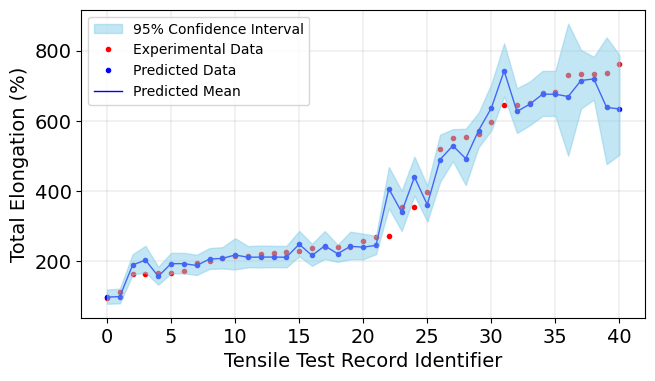

Run # 1 Fold # 2
[iter 0] loss=6.4902 val_loss=6.5827 scale=1.0000 norm=0.7311
[iter 100] loss=6.0662 val_loss=6.1570 scale=2.0000 norm=1.0226
[iter 200] loss=5.6166 val_loss=5.6884 scale=2.0000 norm=0.9076
[iter 300] loss=5.2199 val_loss=5.2847 scale=2.0000 norm=0.8594
[iter 400] loss=4.8707 val_loss=4.9462 scale=2.0000 norm=0.8070
[iter 500] loss=4.5793 val_loss=4.7010 scale=2.0000 norm=0.7583
[iter 600] loss=4.3467 val_loss=4.5679 scale=2.0000 norm=0.7322
== Early stopping achieved.
== Best iteration / VAL641 (val_loss=4.5502)
Pearson CC: 0.991241391714693
R2 score: 0.9808217375874994
RMSE: 31.692326017981134
MAE: 20.947093022947996
Coverage: 87.8048780487805
Median Interval Width: 78.4004441786389
Composite Metric: 0.6617253428100126


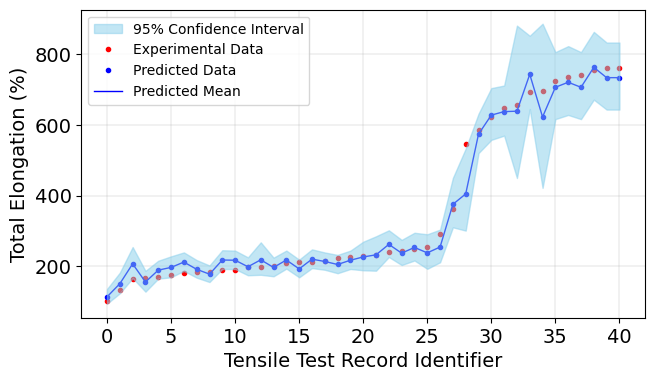

Run # 1 Fold # 3
[iter 0] loss=6.5015 val_loss=6.5944 scale=1.0000 norm=0.7187
[iter 100] loss=6.0070 val_loss=6.0863 scale=2.0000 norm=0.9714
[iter 200] loss=5.5632 val_loss=5.6338 scale=2.0000 norm=0.8936
[iter 300] loss=5.1671 val_loss=5.2410 scale=2.0000 norm=0.8460
[iter 400] loss=4.8211 val_loss=4.9272 scale=2.0000 norm=0.7936
[iter 500] loss=4.5230 val_loss=4.7109 scale=2.0000 norm=0.7440
== Early stopping achieved.
== Best iteration / VAL594 (val_loss=4.6491)
Pearson CC: 0.9861978493868959
R2 score: 0.9680522566780534
RMSE: 37.719740821316186
MAE: 24.652632350219577
Coverage: 85.3658536585366
Median Interval Width: 75.80511836947022
Composite Metric: 0.6435418327816895


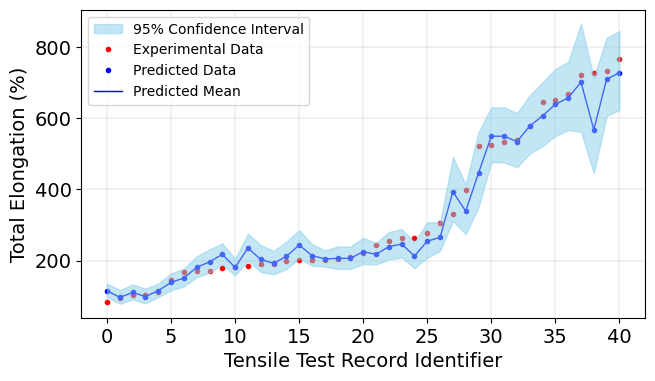

Run # 1 Fold # 4
[iter 0] loss=6.5652 val_loss=6.6163 scale=1.0000 norm=0.7122
[iter 100] loss=5.9873 val_loss=6.1038 scale=2.0000 norm=0.9487
[iter 200] loss=5.5298 val_loss=5.6823 scale=2.0000 norm=0.9002
[iter 300] loss=5.1155 val_loss=5.3739 scale=2.0000 norm=0.8648
[iter 400] loss=4.7555 val_loss=5.2574 scale=2.0000 norm=0.8116
== Early stopping achieved.
== Best iteration / VAL411 (val_loss=5.2548)
Pearson CC: 0.9733276634129802
R2 score: 0.9451799426922252
RMSE: 44.82152943141294
MAE: 23.979955852288963
Coverage: 97.5609756097561
Median Interval Width: 105.71905328444697
Composite Metric: 0.734072075290664


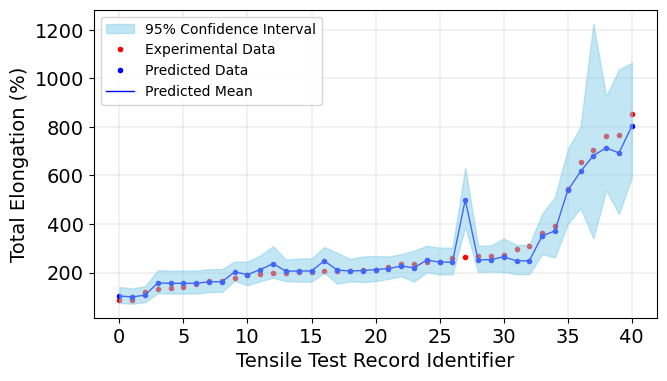

Run # 1 Fold # 5
[iter 0] loss=6.5356 val_loss=6.5936 scale=2.0000 norm=1.4392
[iter 100] loss=6.1151 val_loss=6.1898 scale=2.0000 norm=1.0177
[iter 200] loss=5.6706 val_loss=5.7612 scale=2.0000 norm=0.9088
[iter 300] loss=5.2602 val_loss=5.3604 scale=2.0000 norm=0.8673
[iter 400] loss=4.9049 val_loss=5.0527 scale=2.0000 norm=0.8072
[iter 500] loss=4.6016 val_loss=4.8576 scale=2.0000 norm=0.7495
== Early stopping achieved.
== Best iteration / VAL570 (val_loss=4.8053)
Pearson CC: 0.989161503033003
R2 score: 0.9771828210070652
RMSE: 32.89552115364362
MAE: 25.939379659228972
Coverage: 90.0
Median Interval Width: 83.08090048061322
Composite Metric: 0.6780091151943922


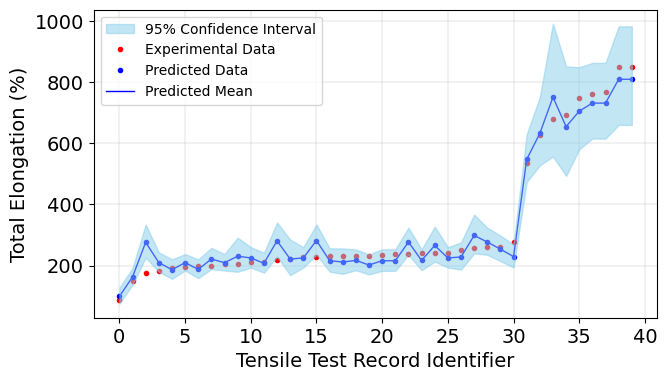

In [19]:
# Evaluate multiple runs of the model
nruns = 1
nfolds = 5

# Metrics for performance evaluation
PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)
MAPE = np.zeros_like(PearsonCC)

test_coverage = np.zeros_like(PearsonCC)
upper_coverage = np.zeros_like(PearsonCC)
lower_coverage = np.zeros_like(PearsonCC)
mean_interval_width = np.zeros_like(PearsonCC)
median_interval_width = np.zeros_like(PearsonCC)
composite_metric = np.zeros_like(PearsonCC)
for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=123+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):
            
            # Display the run number
            print('Run #', j+1, "Fold #", i+1)
            
            X_train, X_test = features.iloc[tr], features.iloc[ts]

            scale = MinMaxScaler()
            X_train = scale.fit_transform(X_train)
            X_test = scale.transform(X_test)

            y_train, y_test = targets[tr], targets[ts]
            X_train, X_val, y_train, Y_val =train_test_split(X_train, y_train, test_size=0.2, random_state=42)
            
            
            model = NGBRegressor(Dist=LogNormal, n_estimators=1000, learning_rate=0.005)

            model.fit(X_train, y_train, X_val=X_val, Y_val=Y_val, early_stopping_rounds=4)

            y_pred_test = model.predict(X_test)
            
            y_test_ngb = model.pred_dist(X_test)

            PearsonCC[j, i] = pearsonr(y_test, y_pred_test)[0]
            R2_score[j, i] = r2_score(y_test, y_pred_test)
            RMSE[j, i] = sqrt(mean_squared_error(y_pred_test, y_test))
            MAE[j, i] = np.mean(abs(y_pred_test-y_test))
            
            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {RMSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')
            
            df_test_low = y_test_ngb.interval(0.95)[0]
            df_test_median = y_pred_test
            df_test_high = y_test_ngb.interval(0.95)[1]
            
            test_coverage[j, i] = coverage(y_test, df_test_low, df_test_high) 
            print(f'Coverage: {test_coverage[j, i]}')

            # Prediction interval width
            median_interval_width[j, i] = np.median(df_test_high - df_test_low)
            print(f'Median Interval Width: {median_interval_width[j, i]}')

            # Composite metric that combines the coverage and the invers of interval width
            composite_metric[j, i] = 0.75*test_coverage[j, i]/100 + 0.25*(1/median_interval_width[j, i])
            print(f'Composite Metric: {composite_metric[j, i]}')

            # Plot the predictions
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
            iteration_list = [i for i in range(len(y_test))]

            y_pred = y_pred_test
            y_std = np.std(np.array(y_pred_test), axis=0)

            ## Uncertainty quantification plot
            ax[0].fill_between(iteration_list, df_test_low, df_test_high, alpha=0.5, color='skyblue', zorder=5, label='95% Confidence Interval')
            ax[0].plot(iteration_list, y_test, 'ro', markersize=3, label="Experimental Data")
            ax[0].plot(iteration_list, y_pred, 'bo', markersize=3, label="Predicted Data")
            ax[0].plot(iteration_list, y_pred, '-', linewidth=1, color="blue", label="Predicted Mean")
            ax[0].legend(fontsize=10, frameon=True, loc="upper left")
            ax[0].set_xlabel("Tensile Test Record Identifier", fontsize=14)
            ax[0].set_ylabel("Total Elongation (%)", fontsize=14)
            ax[0].tick_params(axis='x', labelsize=14)  
            ax[0].tick_params(axis='y', labelsize=14)   

            ax[0].grid(True, which='major', linestyle='-', linewidth='0.25')
            fig.delaxes(ax[1])
            plt.show()

In [20]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'RMSE': RMSE.flatten(),
                    'MAE': MAE.flatten(), 'Coverage': test_coverage.flatten()},index=None)
df1

,Pearson CC,R2 Score,RMSE,MAE,Coverage
0,0.979564,0.958452,44.399576,28.967177,90.243902
1,0.991241,0.980822,31.692326,20.947093,87.804878
2,0.986198,0.968052,37.719741,24.652632,85.365854
3,0.973328,0.945180,44.821529,23.979956,97.560976
4,0.989162,0.977183,32.895521,25.939380,90.000000


In [21]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
RMSE_mean = np.mean(RMSE)
MAE_mean = np.mean(MAE)
test_coverage_mean = np.mean(test_coverage)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
RMSE_std = np.std(RMSE)
MAE_std = np.std(MAE)
test_coverage_std = np.std(test_coverage)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'RMSE Mean': RMSE_mean, 'RMSE Std': RMSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std,
                   'RMSE Std': RMSE_std, 'Test Coverage Mean': test_coverage_mean, 'Test Coverage Std':test_coverage_std},index=[0])
df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std,Test Coverage Mean,Test Coverage Std
0,0.983898,0.006594,0.965938,0.012957,38.305739,5.530668,24.897248,2.613631,90.195122,4.082434


In [22]:
# Data frame
df3 = pd.DataFrame({'Coverage': test_coverage.flatten(), 'Interval Width': median_interval_width.flatten(), 'Composite Metric': composite_metric.flatten()},index=None)
df3

,Coverage,Interval Width,Composite Metric
0,90.243902,79.235860,0.679984
1,87.804878,78.400444,0.661725
2,85.365854,75.805118,0.643542
3,97.560976,105.719053,0.734072
4,90.000000,83.080900,0.678009


In [23]:
# Calculate mean values and standard deviations of the scores
test_coverage_mean = np.mean(test_coverage)

median_interval_width_mean = np.mean(median_interval_width)


test_coverage_std = np.std(test_coverage)

median_interval_width_std = np.std(median_interval_width)


# Data frame
df4 = pd.DataFrame({'Coverage Mean': test_coverage_mean, 'Coverage Std': test_coverage_std,
                    'Interval Width Mean': median_interval_width_mean, 'Interval Width Std':median_interval_width_std
                   },index=[0])
df4

,Coverage Mean,Coverage Std,Interval Width Mean,Interval Width Std
0,90.195122,4.082434,84.448275,10.888208
